# Offline Handwritten Signature Detection & Verification

## Project Overview
This project builds an offline signature verification system using a Convolutional Neural Network (CNN).  
**Problem**: Binary classification to distinguish between **Genuine** and **Forged** signatures.

## 1. Project Setup
We start by setting up our environment, importing necessary libraries, and ensuring reproducibility.

In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Set Random Seeds for Reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Detected: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

print(f"TensorFlow Version: {tf.__version__}")

No GPU detected. Running on CPU.
TensorFlow Version: 2.20.0


## 2. Data Preparation
The dataset is located in the `signatures` directory. It is organized by user ID (e.g., `0001` for genuine, `0001_forg` for forged).  
We need to reorganize this into a standard format for Keras:
```
data/
  train/
    genuine/
    forged/
  test/
    genuine/
    forged/
```
The following script performs this split (80% Train, 20% Test).

In [2]:
SOURCE_DIR = "signatures"
DATA_DIR = "data"

def prepare_dataset(source_dir, data_dir, split_ratio=0.8):
    if os.path.exists(data_dir):
        print(f"'{data_dir}' already exists. Skipping data preparation to avoid overwriting.")
        return

    print(f"Preparing data from '{source_dir}' to '{data_dir}'...")
    
    # Create target directories
    for split in ['train', 'test']:
        for category in ['genuine', 'forged']:
            os.makedirs(os.path.join(data_dir, split, category), exist_ok=True)

    # Get all subdirectories
    subdirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    
    count_genuine = 0
    count_forged = 0

    for folder in subdirs:
        src_folder_path = os.path.join(source_dir, folder)
        
        # Determine category based on folder name suffix
        if folder.endswith('_forg'):
            category = 'forged'
        else:
            category = 'genuine'
            
        files = [f for f in os.listdir(src_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        random.shuffle(files)
        
        split_index = int(len(files) * split_ratio)
        train_files = files[:split_index]
        test_files = files[split_index:]
        
        # Copy files
        for f in train_files:
            shutil.copy(os.path.join(src_folder_path, f), os.path.join(data_dir, 'train', category, f))
            
        for f in test_files:
            shutil.copy(os.path.join(src_folder_path, f), os.path.join(data_dir, 'test', category, f))

        if category == 'genuine': count_genuine += len(files)
        else: count_forged += len(files)

    print(f"Data Prep Complete!")
    print(f"Total Genuine: {count_genuine}, Total Forged: {count_forged}")

# Run Data Prep
prepare_dataset(SOURCE_DIR, DATA_DIR)

Preparing data from 'signatures' to 'data'...
Data Prep Complete!
Total Genuine: 8028, Total Forged: 9560


## 3. Data Loading
We use `image_dataset_from_directory` to load images efficiently. We also create a validation set from the training data.

In [3]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

print("Loading Training Set:")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

print("\nLoading Validation Set:")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

print("\nLoading Test Set:")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False # Important for evaluation metrics later
)

class_names = train_ds.class_names
print(f"\nClass Names: {class_names}") # Should be ['forged', 'genuine']

Loading Training Set:
Found 3161 files belonging to 2 classes.
Using 2529 files for training.

Loading Validation Set:
Found 3161 files belonging to 2 classes.
Using 632 files for validation.

Loading Test Set:
Found 819 files belonging to 2 classes.

Class Names: ['forged', 'genuine']


### visualize Samples

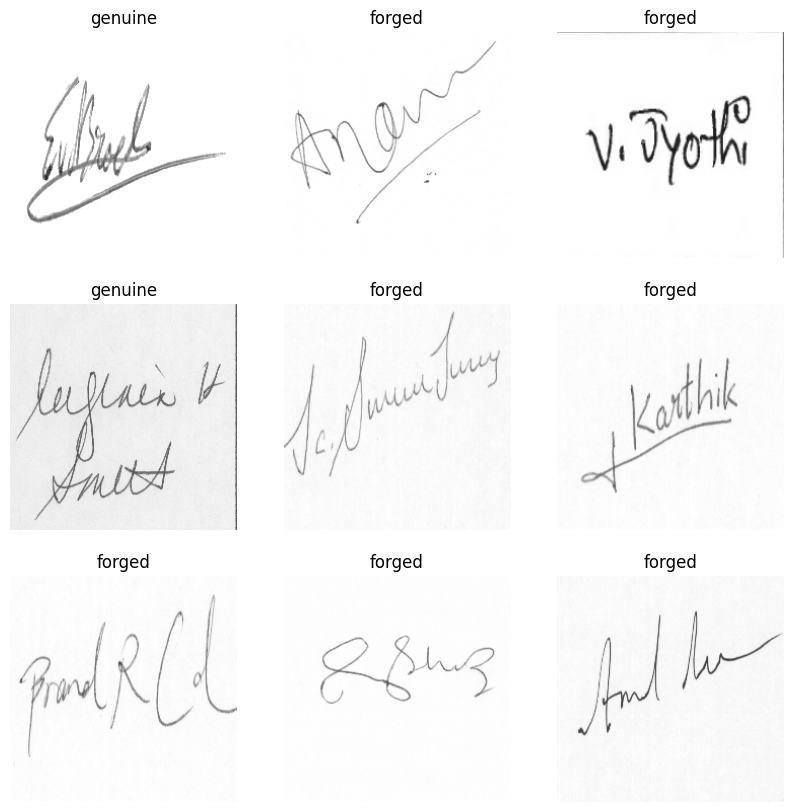

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.show()

## 4. Preprocessing & Augmentation
We build a preprocessing pipeline that:
1. Rescales pixel values to [0, 1] (Normalization). 
2. Applies data augmentation (Random Flip, Rotation, Zoom) to prevent overfitting.

In [5]:
# Improve performance with buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(filename='train_cache.tf').prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache(filename='val_cache.tf').prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache(filename='test_cache.tf').prefetch(buffer_size=AUTOTUNE)

# Data Augmentation Layer
data_augmentation = models.Sequential([
    layers.Rescaling(1./255),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# Preprocessing Layer for Test (Only Rescaling)
resize_and_rescale = models.Sequential([
    layers.Rescaling(1./255)
])

## 5. CNN Model Design
We will design a custom CNN architecture suitable for binary image classification.
- **Conv2D**: Extracts features (edges, curves).
- **MaxPooling2D**: Reduces spatial dimensions.
- **Dropout**: Prevents overfitting.
- **Dense**: Classification layers.
- **Sigmoid Output**: Returns probability between 0 and 1.

In [6]:
def build_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        data_augmentation, # Apply augmentation on input
        
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid') # Binary output
    ])
    return model

cnn_model = build_cnn_model()
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
cnn_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Train Custom CNN ---
cnn_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('signature_model_cnn.keras', save_best_only=True, monitor='val_loss')
]

print("Training Custom CNN...")
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=cnn_callbacks
)


## 5.1 Alternative: Transfer Learning (MobileNetV2)
This model uses a pre-trained backbone (MobileNetV2) to improve accuracy.


In [7]:
def build_mobilenet_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs)

mobilenet_model = build_mobilenet_model()

mobilenet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435,905 (9.29 MB)

 Trainable params: 175,105 (684.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [9]:
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


## 6. Training
We train the model using:
- **Loss**: Binary Crossentropy
- **Optimizer**: Adam
- **Callbacks**: EarlyStopping (to stop when validation loss stops improving) and ModelCheckpoint.

In [10]:
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('signature_model_mobilenet.keras', save_best_only=True, monitor='val_loss')
]

EPOCHS = 5 # Adjust as needed

print("--- Phase 1: Training Top Layers ---")
mobilenet_history = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

print("\n--- Phase 2: Fine-Tuning ---")
mobilenet_model.trainable = True # Unfreeze all layers
mobilenet_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

FINE_TUNE_EPOCHS = 2
total_epochs = EPOCHS + FINE_TUNE_EPOCHS

mobilenet_history_fine = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=mobilenet_history.epoch[-1],
    callbacks=callbacks_list
)

--- Phase 1: Training Top Layers ---
Epoch 1/5
 670/1262 ━━━━━━━━━━━━━━━━━━━━ 1:35 161ms/step - accuracy: 0.5000 - loss: 0.9782 - precision: 0.5195 - recall: 0.4762

KeyboardInterrupt: 

In [8]:
# Plot Training History (Combined)
acc = mobilenet_history.history['accuracy'] + mobilenet_history_fine.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy'] + mobilenet_history_fine.history['val_accuracy']
loss = mobilenet_history.history['loss'] + mobilenet_history_fine.history['loss']
val_loss = mobilenet_history.history['val_loss'] + mobilenet_history_fine.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([len(mobilenet_history.history['accuracy'])-1, len(mobilenet_history.history['accuracy'])-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([len(mobilenet_history.history['accuracy'])-1, len(mobilenet_history.history['accuracy'])-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'mobilenet_history' is not defined

## 7. Evaluation
We evaluate the model on the unseen test set using Confusion Matrix and ROC Curve.

In [ ]:
print("--- Evaluate Custom CNN ---")
loss, accuracy, precision, recall = cnn_model.evaluate(test_ds)
print(f"Custom CNN Test Accuracy: {accuracy*100:.2f}%")


465/465 ━━━━━━━━━━━━━━━━━━━━ 50s 104ms/step - accuracy: 0.4955 - loss: 0.7016 - precision: 0.0000e+00 - recall: 0.0000e+00
MobileNetV2 Test Accuracy: 49.55%
465/465 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step


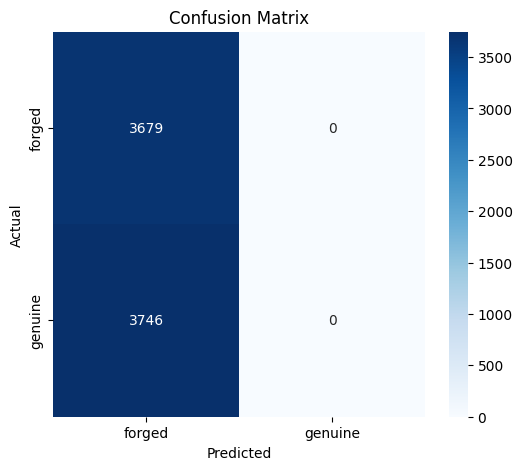

              precision    recall  f1-score   support

      forged       0.50      1.00      0.66      3679
     genuine       0.00      0.00      0.00      3746

    accuracy                           0.50      7425
   macro avg       0.25      0.50      0.33      7425
weighted avg       0.25      0.50      0.33      7425



c:\Users\OMEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\OMEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\OMEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [8]:
# Evaluate on Test Set
loss, accuracy, precision, recall = mobilenet_model.evaluate(test_ds)
print(f"MobileNetV2 Test Accuracy: {accuracy*100:.2f}%")

# Get predictions
predictions = mobilenet_model.predict(test_ds)
y_pred = (predictions > 0.5).astype(int).flatten()

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0).flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

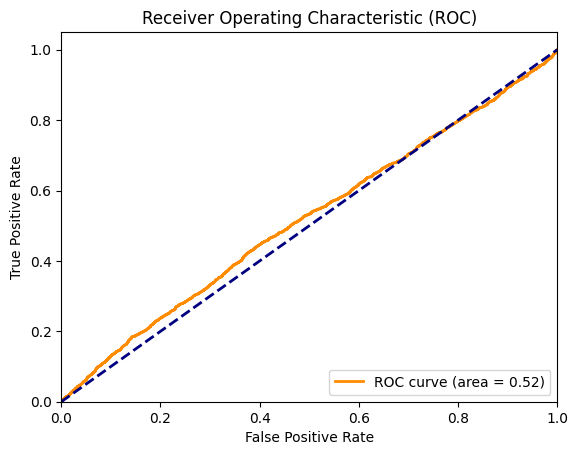

In [9]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 8. Prediction & Verification Logic
We create a standalone function to verify a single signature image.

Testing: data\test\genuine\0001_01.jpg


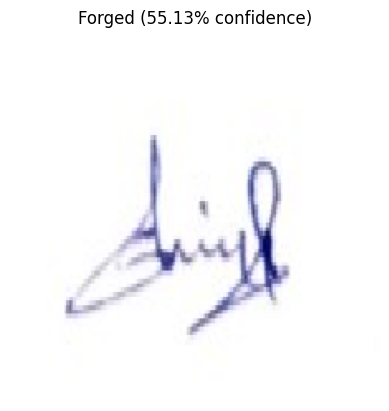

('Forged', 0.4486539661884308)

In [10]:
def verify_signature(image_path, model, threshold=0.5):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create batch axis
    img_array = img_array / 255.0 # Rescale manually to match model input

    prediction = model.predict(img_array, verbose=0)[0][0]
    
    label = "Genuine" if prediction > threshold else "Forged"
    confidence = prediction if label == "Genuine" else 1 - prediction
    
    plt.imshow(img)
    plt.title(f"{label} ({confidence*100:.2f}% confidence)")
    plt.axis("off")
    plt.show()
    
    return label, float(prediction)

# Test with a sample from the test set
sample_image_path = os.path.join(DATA_DIR, 'test', 'genuine', os.listdir(os.path.join(DATA_DIR, 'test', 'genuine'))[0])
print(f"Testing: {sample_image_path}")
verify_signature(sample_image_path, mobilenet_model)

## 9. Offline Usage
The model is saved as `signature_model.keras`. You can load it later without retraining.

Model loaded successfully!


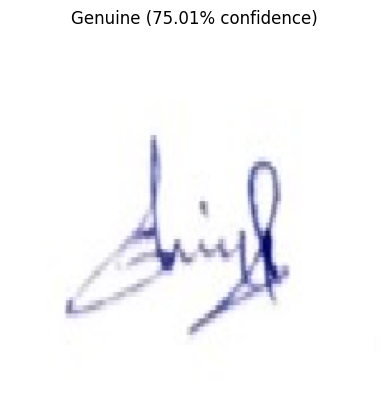

('Genuine', 0.7501465082168579)

In [11]:
# Load the model
loaded_model = tf.keras.models.load_model('signature_model_mobilenet.keras')
print("Model loaded successfully!")

# Use loaded model
verify_signature(sample_image_path, loaded_model)